### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras as ker
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_excel("Sensor data[0474D,04750,04754,04756,04757,0475A,0475C,0475D,04762,04763,04765,04768,0476E,04771,04773,0477F,04787,04789,0478A,0478C](01_01_2024-15_05_2024).xlsx",sheet_name=None)

In [3]:
def extract_data_from_sheet(df):
    sensor_name = df.iloc[0, 1]

    extracted_df = df.iloc[3:].reset_index(drop=True)

    extracted_df.columns = ['Time', 'Temperature', 'Humidity']
    extracted_df['Time'] = pd.to_datetime(extracted_df['Time'], format='%d-%m-%Y %H:%M')
    
    extracted_df['Sensor Info'] = sensor_name

    return extracted_df

In [4]:
data_frames = []

for sheet_name, df in data.items():
    extracted_df = extract_data_from_sheet(df)
    data_frames.append(extracted_df)

In [5]:
combined_data = pd.concat(data_frames, ignore_index=True)

In [6]:
combined_data.head()

,Time,Temperature,Humidity,Sensor Info
0,2024-04-16 13:09:53,21.95,50.3,0474D T/RH IP67
1,2024-04-16 13:14:52,22.5,34.7,0474D T/RH IP67
2,2024-04-16 13:19:54,24.05,34.7,0474D T/RH IP67
3,2024-04-16 13:24:53,24.25,34.7,0474D T/RH IP67
4,2024-04-16 13:29:52,24.15,35.2,0474D T/RH IP67


In [7]:
def split_sensor_info(sensor_info):
    parts = sensor_info.split(' ')
    return pd.Series([parts[0], sensor_info])

combined_data[['Sensor ID', 'Sensor Name']] = combined_data['Sensor Info'].apply(split_sensor_info)

In [8]:
combined_data = combined_data.drop('Sensor Info', axis=1)

In [9]:
combined_data.isnull().sum()

Time              0
Temperature    2235
Humidity       2235
Sensor ID         0
Sensor Name       0
dtype: int64

In [10]:
combined_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-04-16 13:09:53,21.95,50.3,0474D,0474D T/RH IP67
1,2024-04-16 13:14:52,22.5,34.7,0474D,0474D T/RH IP67
2,2024-04-16 13:19:54,24.05,34.7,0474D,0474D T/RH IP67
3,2024-04-16 13:24:53,24.25,34.7,0474D,0474D T/RH IP67
4,2024-04-16 13:29:52,24.15,35.2,0474D,0474D T/RH IP67


In [11]:
sample_dataset = combined_data.copy()

In [12]:
sample_dataset = sample_dataset[['Time','Temperature','Sensor ID']]

In [13]:
sample_dataset.head()

,Time,Temperature,Sensor ID
0,2024-04-16 13:09:53,21.95,0474D
1,2024-04-16 13:14:52,22.5,0474D
2,2024-04-16 13:19:54,24.05,0474D
3,2024-04-16 13:24:53,24.25,0474D
4,2024-04-16 13:29:52,24.15,0474D


In [14]:
sample_dataset['Temperature'] = sample_dataset['Temperature'].astype('float')

In [15]:
sensor_ids = sample_dataset['Sensor ID'].unique()
size_x = 5
size_y = 4

output_dir = "sensor_heatmaps"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

frames = []
for sensor_id in sensor_ids:
    sensor_data = sample_dataset[sample_dataset['Sensor ID'] == sensor_id].reset_index(drop=True)

    temperature_grid = np.zeros((size_x, size_y))

    for index, row in sensor_data.iterrows():
        x = index % size_x
        y = index // size_x
        if x < size_x and y < size_y:
            temperature_grid[x, y] = row['Temperature']

    plt.figure(figsize=(10, 6))
    sns.heatmap(temperature_grid, cmap='hot', cbar_kws={'label': 'Temperature (°C)'}, fmt=".2f", xticklabels=False, yticklabels=False,cbar=False)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    output_file = os.path.join(output_dir, f"heatmap_{sensor_id}.png")
    plt.savefig(output_file)
    plt.close()

    frames.append(output_file)

print(f"Heat maps saved in the directory: {output_dir}")

Heat maps saved in the directory: sensor_heatmaps


In [16]:
video_output = "sensor_heatmaps_video.avi"
frame = cv2.imread(frames[0])
height, width, _ = frame.shape

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
video = cv2.VideoWriter(video_output, fourcc, 5.0, (width, height))

prev_frame = cv2.imread(frames[0])

for frame_path in frames[1:]:
    next_frame = cv2.imread(frame_path)
    
    for i in range(1, 10):
        alpha = i / 10.0
        interpolated_frame = cv2.addWeighted(prev_frame, 1 - alpha, next_frame, alpha, 0)
        video.write(interpolated_frame)

    prev_frame = next_frame

video.release()
cv2.destroyAllWindows()

print(f"Video saved as: {video_output}")

Video saved as: sensor_heatmaps_video.avi


In [17]:
combined_data['Humidity'] = combined_data['Humidity'].astype('float')
combined_data['Temperature'] = combined_data['Temperature'].astype('float')

In [18]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        if not np.isnan(data[i]) and not np.isnan(data[i-n_steps:i]).any():
            X.append(data[i-n_steps:i])
            y.append(data[i])
    return np.array(X), np.array(y)

In [19]:
def build_model(input_shape):
    model = ker.models.Sequential([
        ker.layers.Input(shape = input_shape),
        ker.layers.Dense(256,activation='relu'),
        ker.layers.Dense(128,activation='relu'),
        ker.layers.Dense(64,activation='relu'),
        ker.layers.Dense(32,activation='relu'),
        ker.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [20]:
def fill_missing_values(data, model, feature_name, n_steps):
    data_copy = data.copy()
    feature_data = data_copy[feature_name].values
    for i in range(n_steps, len(feature_data)):
        if np.isnan(feature_data[i]):
            if np.isnan(feature_data[i-n_steps:i]).any():
                continue
            X_input = feature_data[i-n_steps:i].reshape(1, -1)
            predicted_value = model.predict(X_input, verbose=0)
            feature_data[i] = np.round(predicted_value.item(), 2)
    data_copy[feature_name] = feature_data
    return data_copy

In [21]:
def train_and_fill(data, feature_name, n_steps):
    feature_data = data[feature_name].values
    X, y = create_sequences(feature_data, n_steps)
    input_shape = (X.shape[1],)
    model = build_model(input_shape)
    model.fit(X, y, epochs=100, batch_size=32, validation_split=0.3)
    filled_data = fill_missing_values(data, model, feature_name, n_steps)
    return filled_data

In [22]:
if combined_data['Temperature'].isnull().sum() > 0 or combined_data['Humidity'].isnull().sum() > 0:
    if combined_data['Temperature'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Temperature', combined_data['Temperature'].isnull().sum())
    if combined_data['Humidity'].isnull().sum() > 0:
        combined_data = train_and_fill(combined_data, 'Humidity', combined_data['Humidity'].isnull().sum())
else:
    print('No null values detected!!!!!!')

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 194.2767 - val_loss: 14.1725
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5281 - val_loss: 4.0979
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1123 - val_loss: 2.9461
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5413 - val_loss: 11.2914
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8878 - val_loss: 1.6314
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0369 - val_loss: 3.0875
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8933 - val_loss: 3.5554
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0155 - val_loss: 2.9046
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2622 - val_loss: 2.0860
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8929 - val_loss: 1.3984
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4805 - val_loss: 3.6701
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss:

In [23]:
final_dataset = combined_data.dropna()

In [24]:
final_dataset.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name
0,2024-04-16 13:09:53,21.95,50.3,0474D,0474D T/RH IP67
1,2024-04-16 13:14:52,22.50,34.7,0474D,0474D T/RH IP67
2,2024-04-16 13:19:54,24.05,34.7,0474D,0474D T/RH IP67
3,2024-04-16 13:24:53,24.25,34.7,0474D,0474D T/RH IP67
4,2024-04-16 13:29:52,24.15,35.2,0474D,0474D T/RH IP67


In [25]:
def detect_anomalies(sensor_data, sensor_id):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for ax, column in zip(axes, ['Temperature', 'Humidity']):
        mean = sensor_data[column].mean()
        std_dev = sensor_data[column].std()
        lower_bound = mean - 2 * std_dev
        upper_bound = mean + 2 * std_dev
        
        sensor_data[f'{column}_anomaly'] = np.where(
            (sensor_data[column] < lower_bound) | (sensor_data[column] > upper_bound), 1, 0)
        
        ax.hist(sensor_data[column], bins=30, alpha=0.6, color='g', density=True)
        
        x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
        p = (1/(std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
        ax.plot(x, p, 'k', linewidth=2)
        
        anomalies = sensor_data[sensor_data[f'{column}_anomaly'] == 1]
        ax.scatter(anomalies[column], np.zeros(len(anomalies)), color='r')
        
        ax.set_title(f'Normal Distribution of {column} for Sensor {sensor_id}')
        ax.set_xlabel(column)
        ax.set_ylabel('Density')
        ax.axvline(x=lower_bound, color='b', linestyle='--', label='Lower 2-Sigma')
        ax.axvline(x=upper_bound, color='b', linestyle='--', label='Upper 2-Sigma')
        ax.legend()

    plt.tight_layout()
    plt.show()
    
    return sensor_data

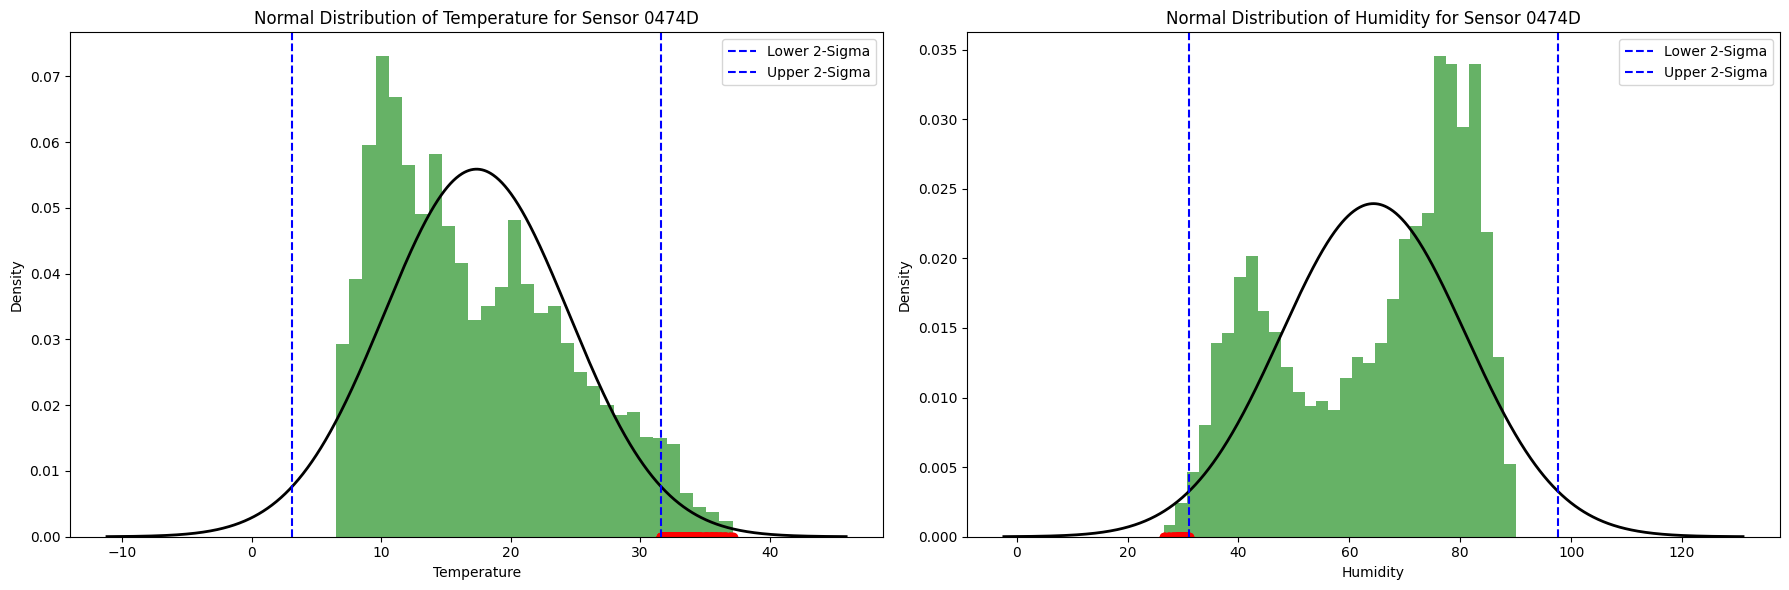

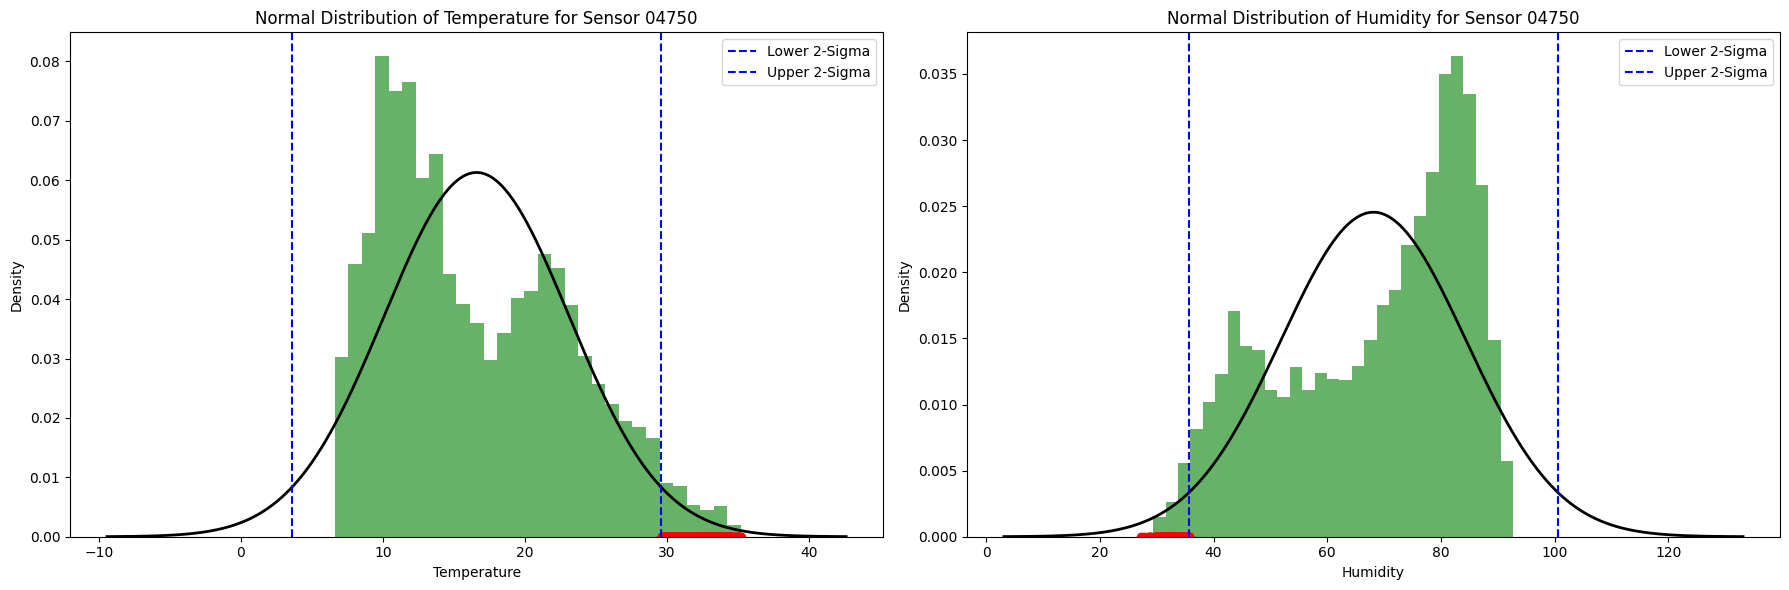

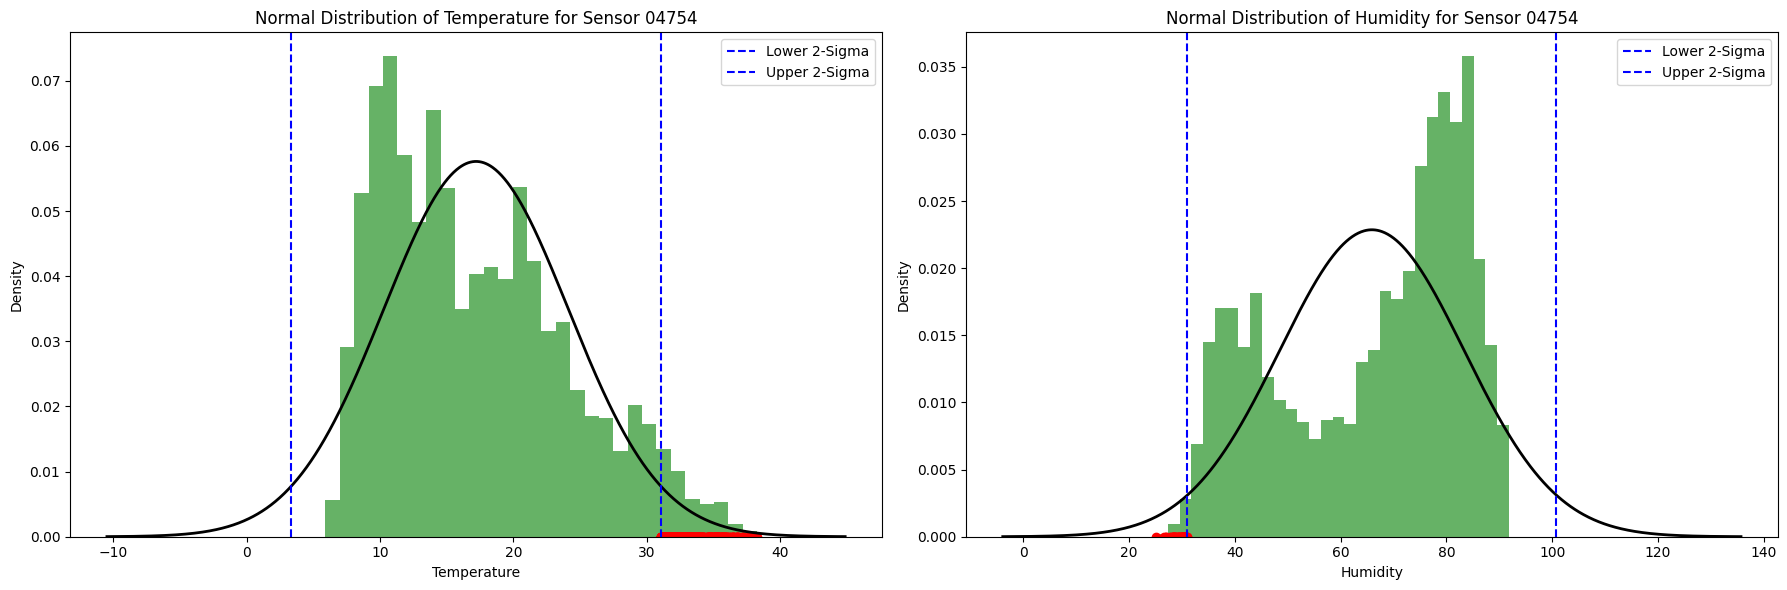

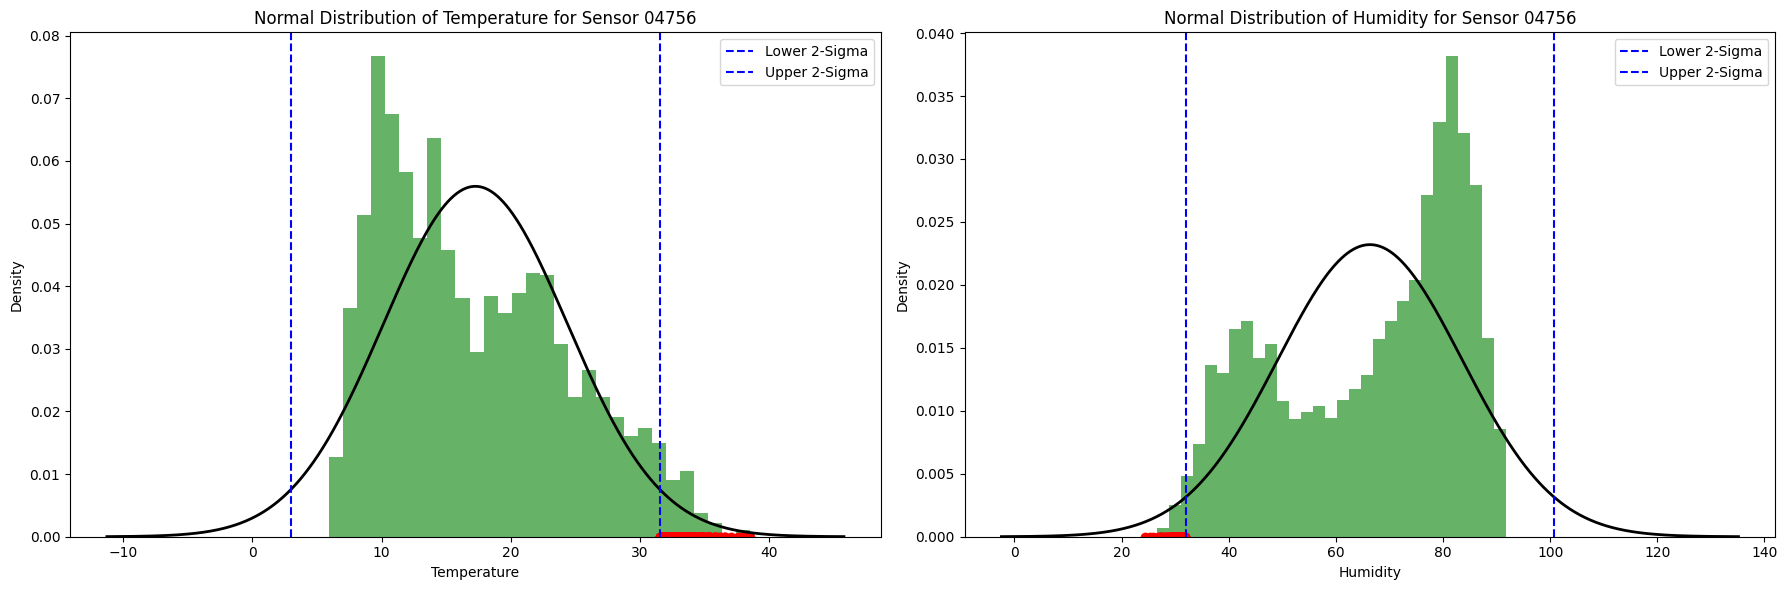

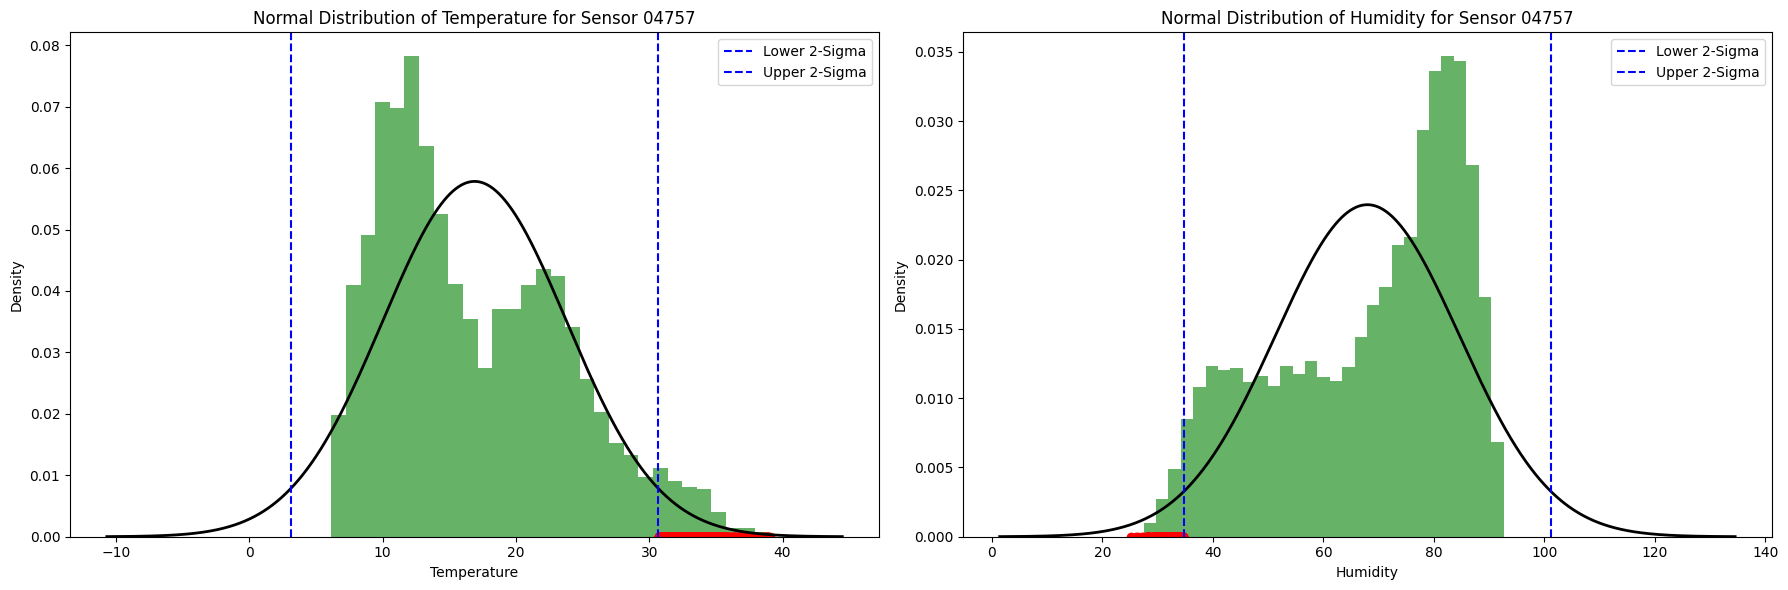

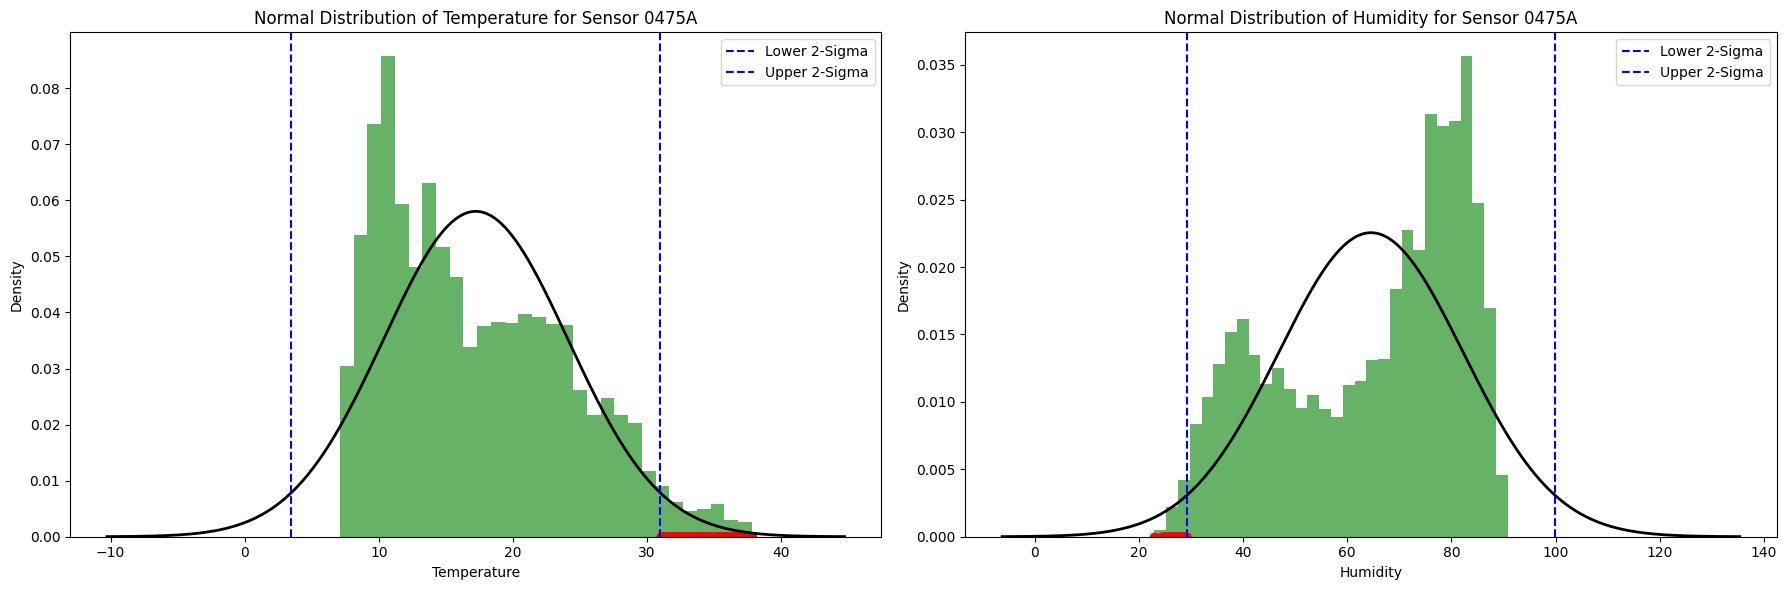

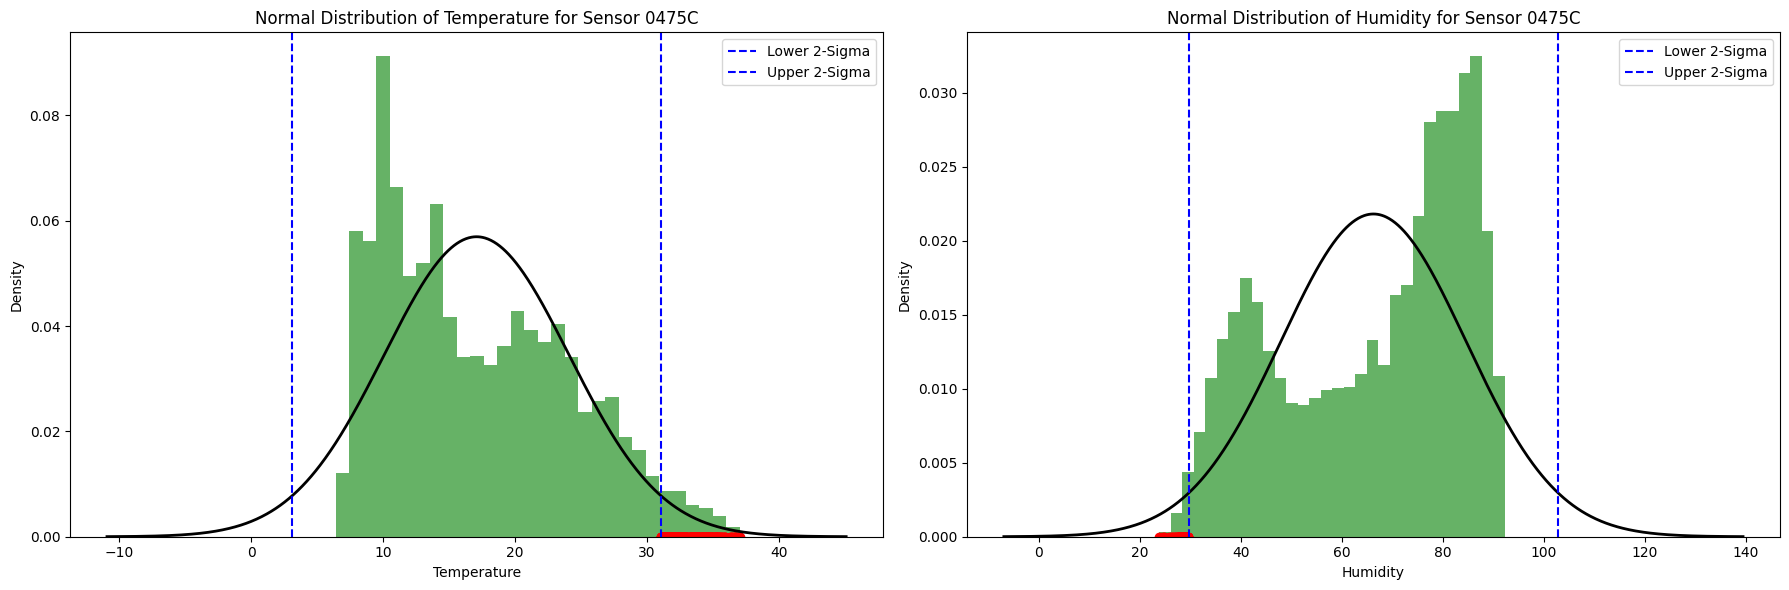

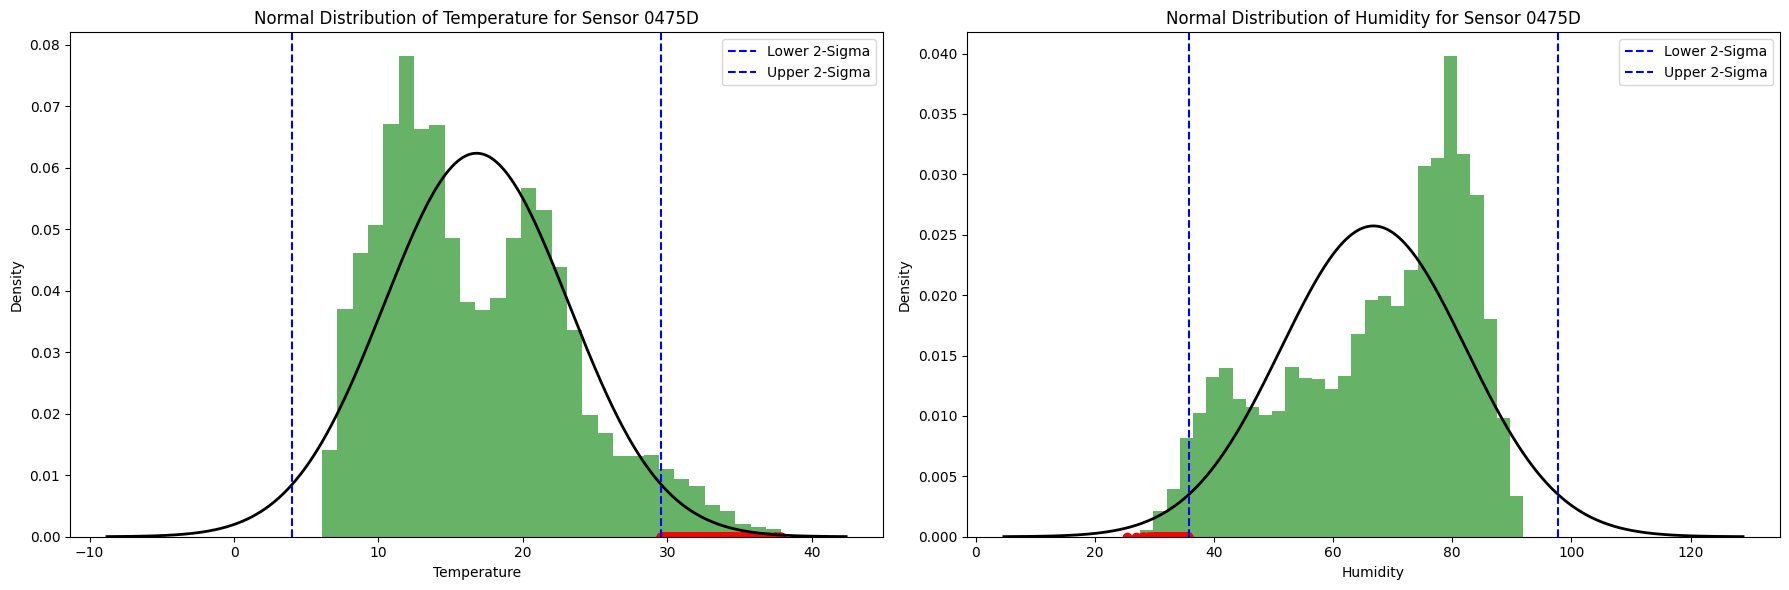

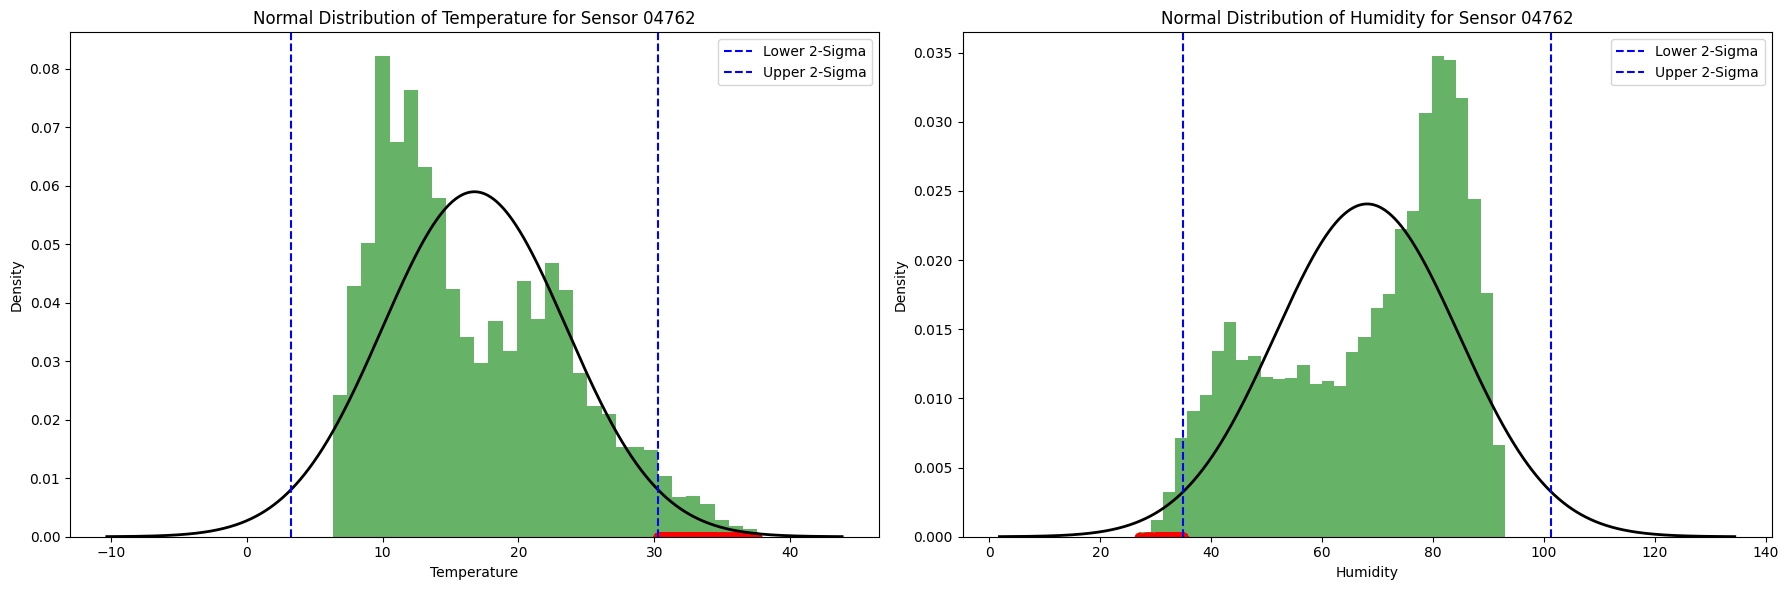

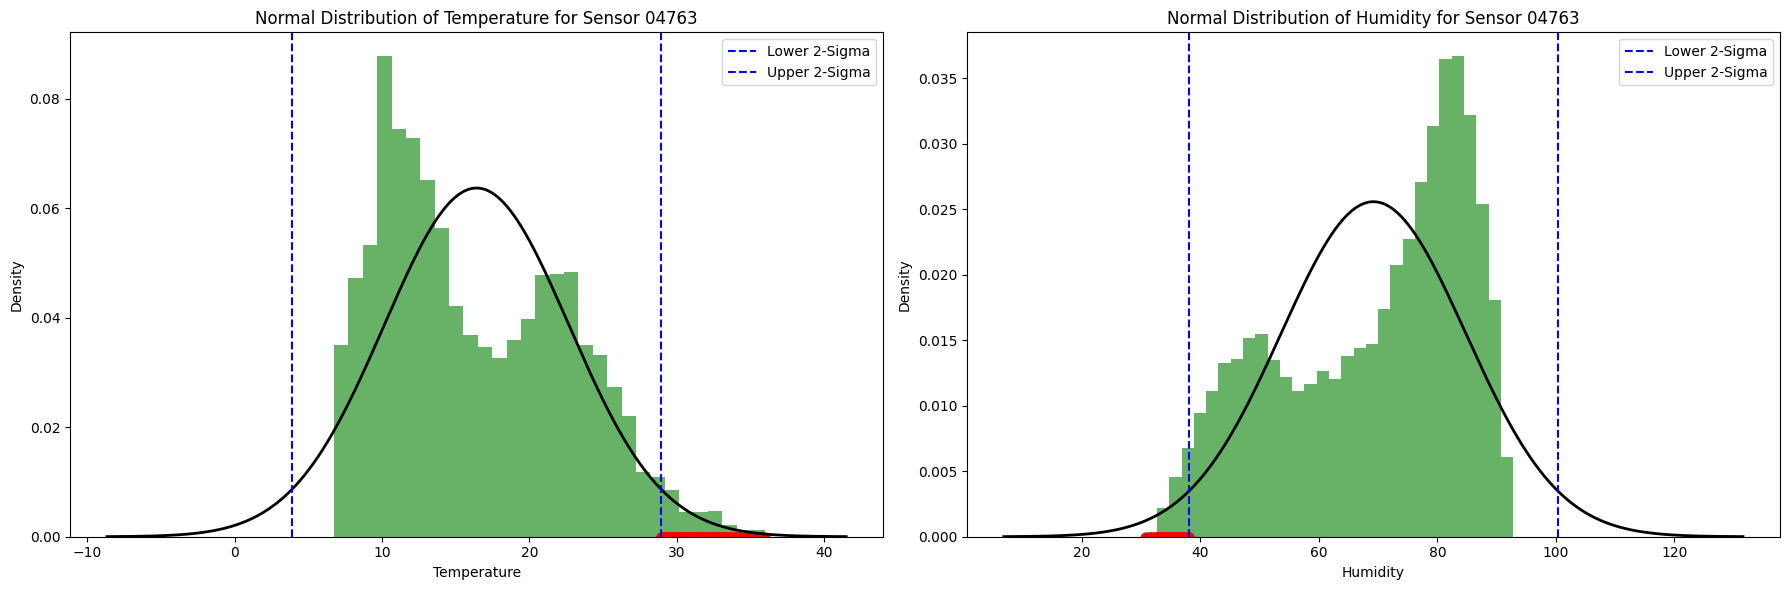

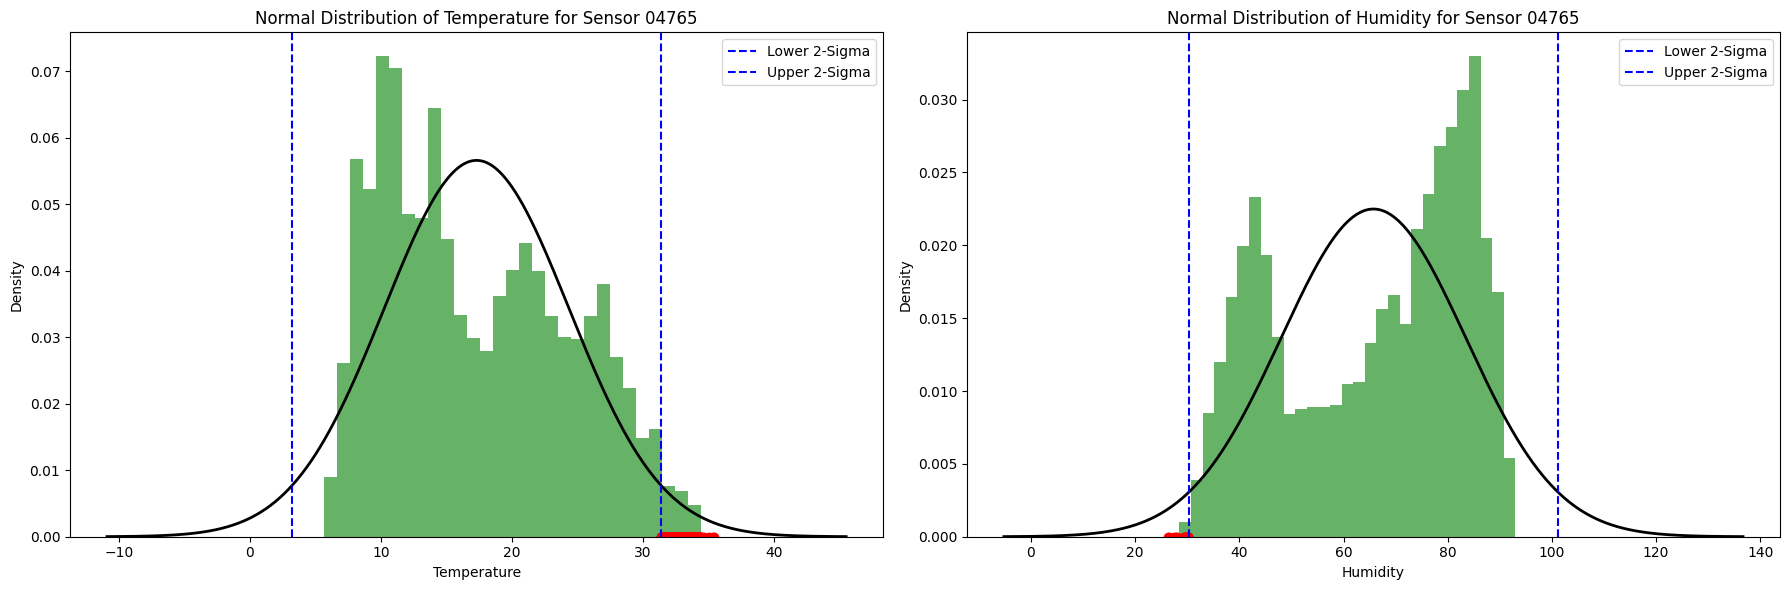

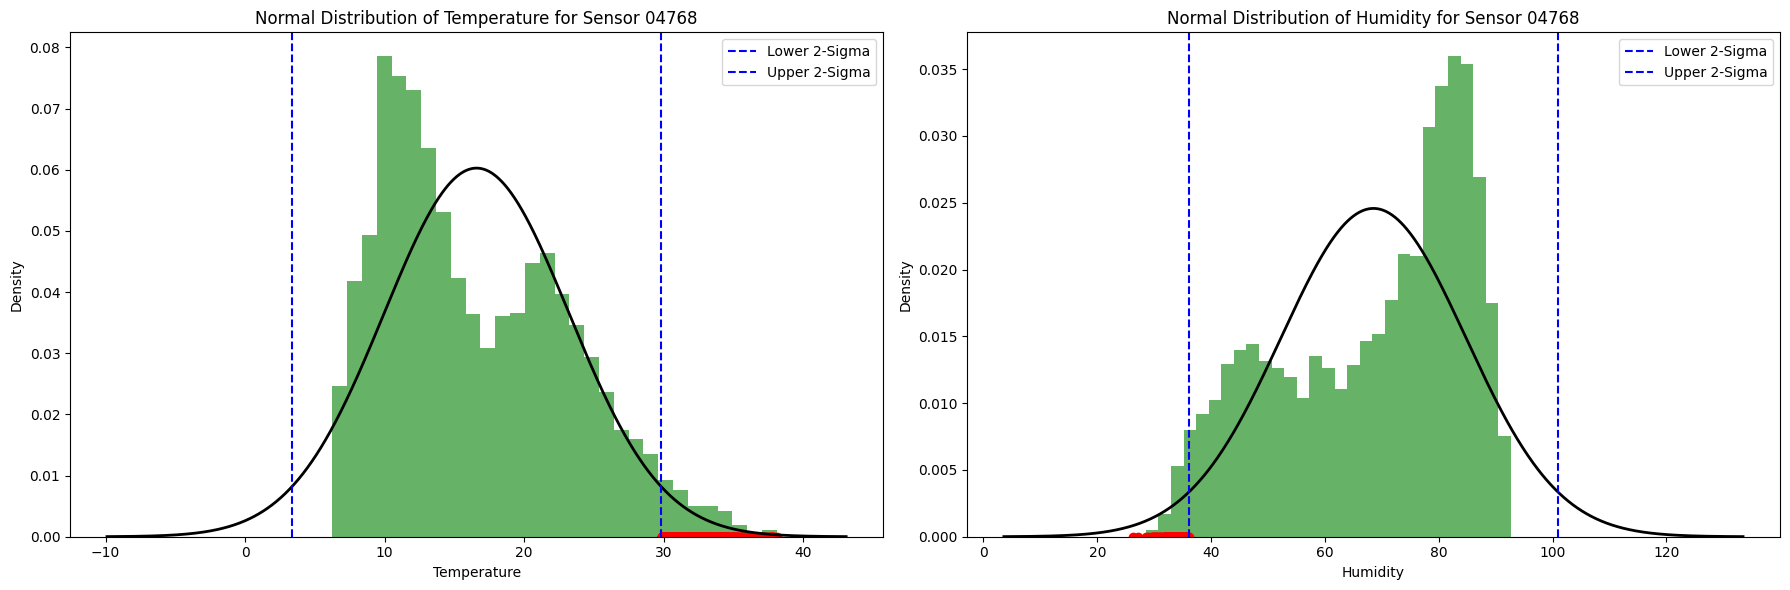

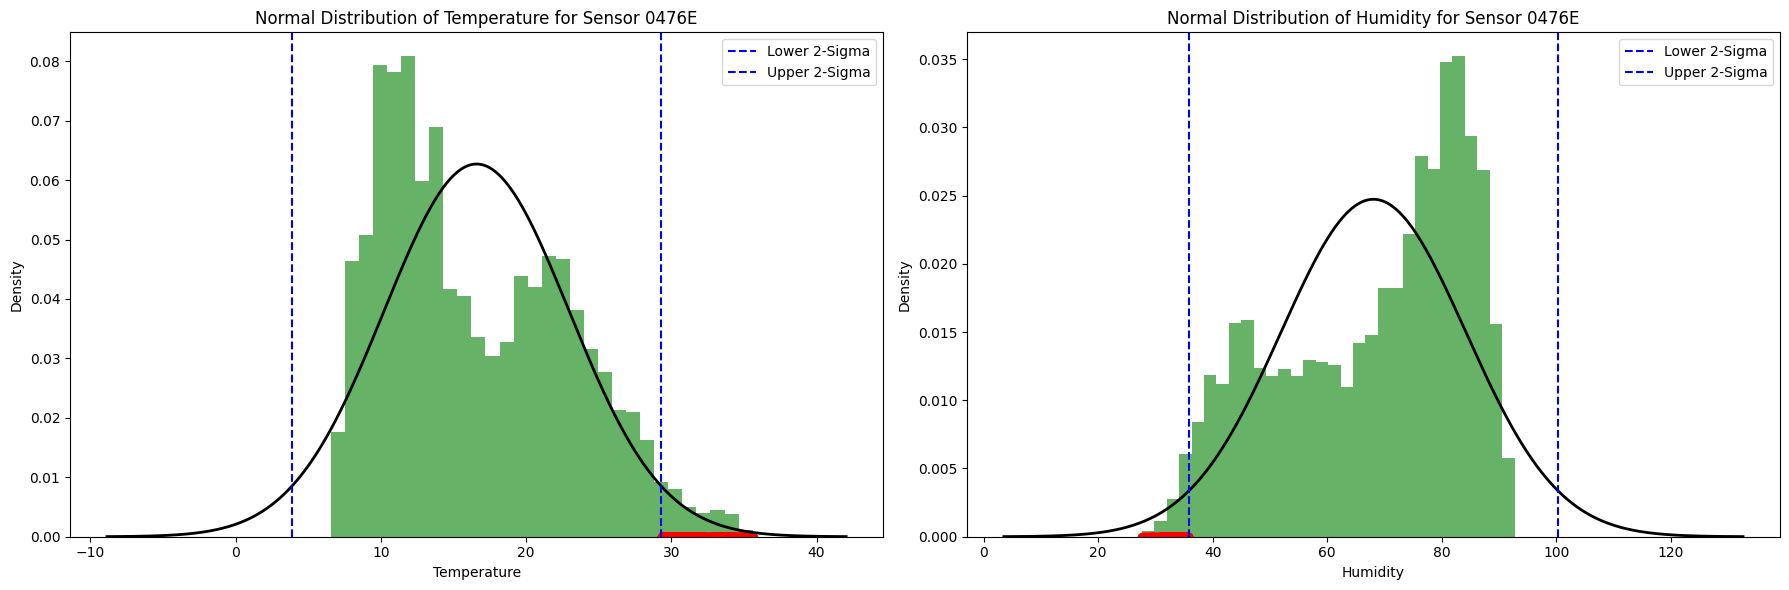

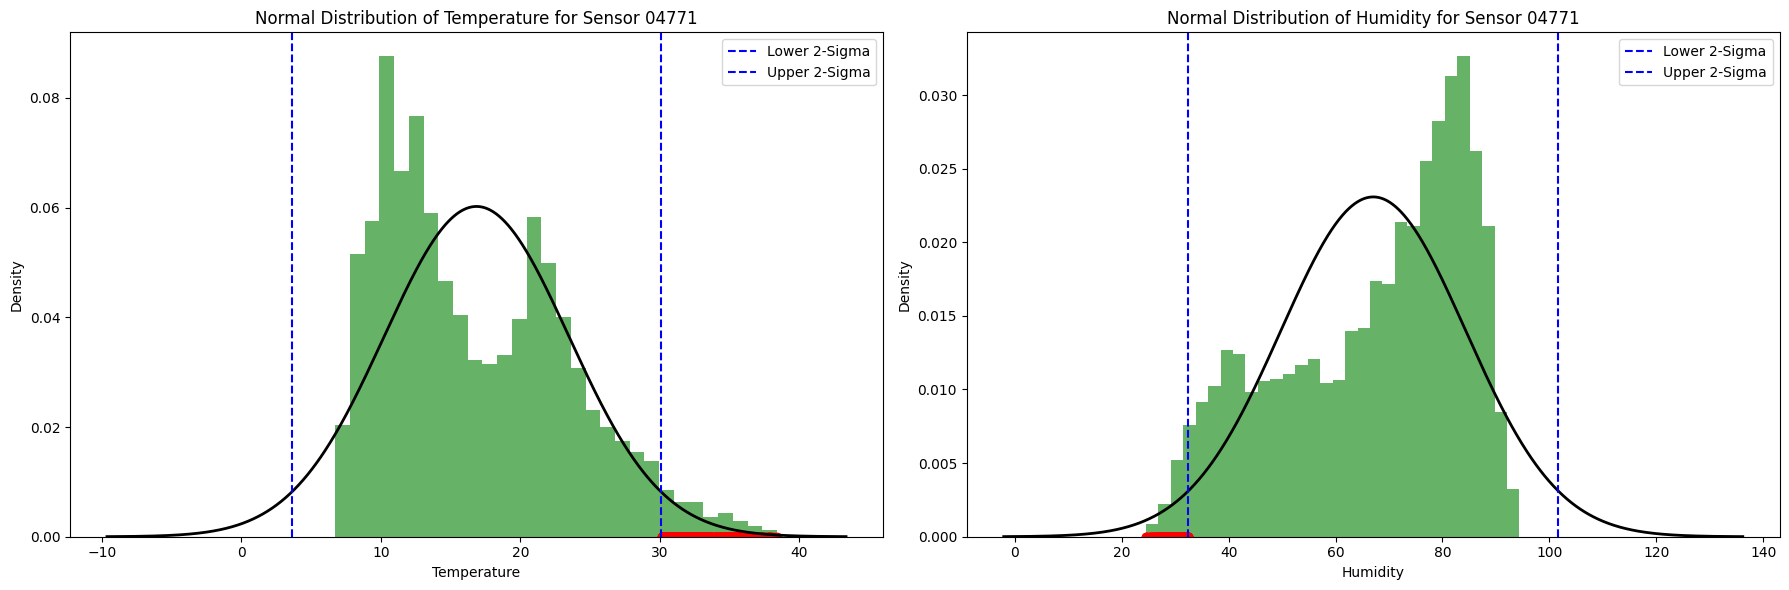

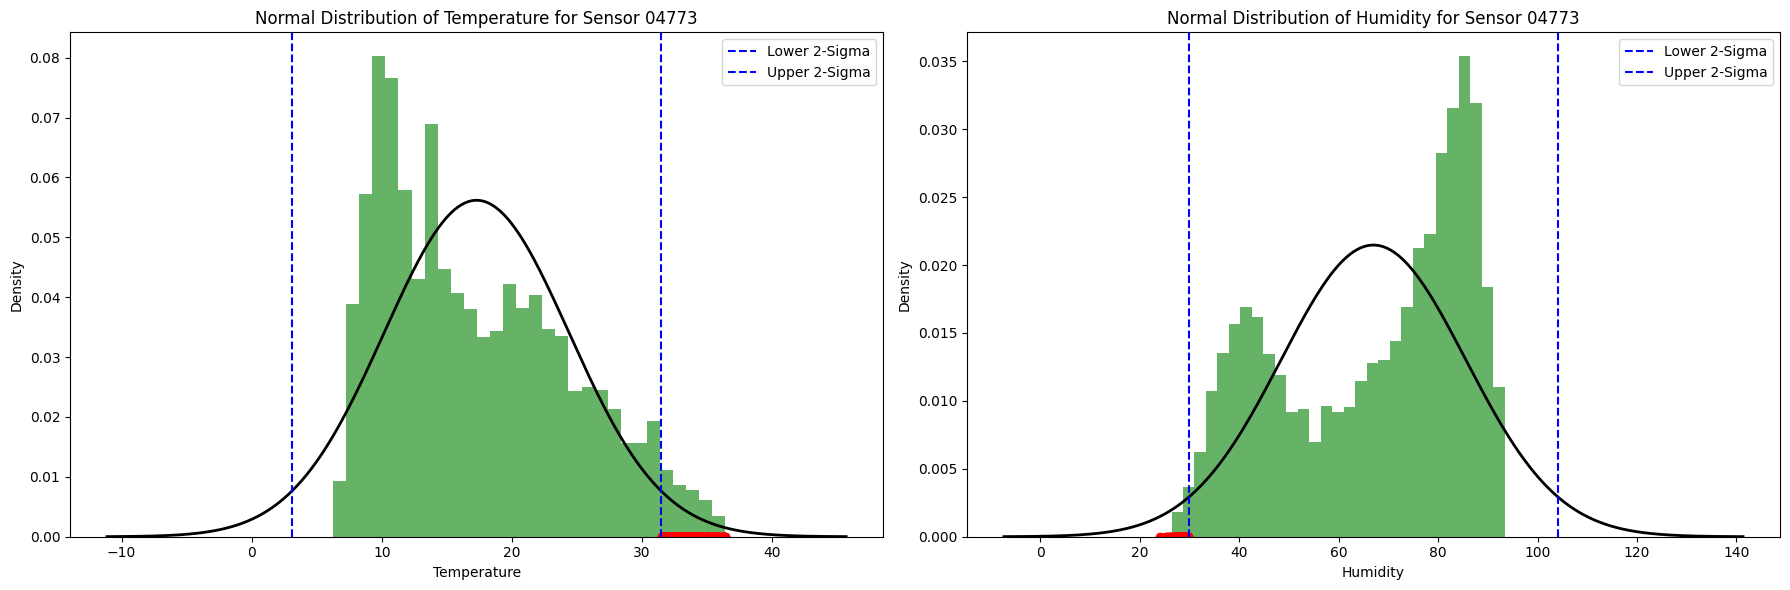

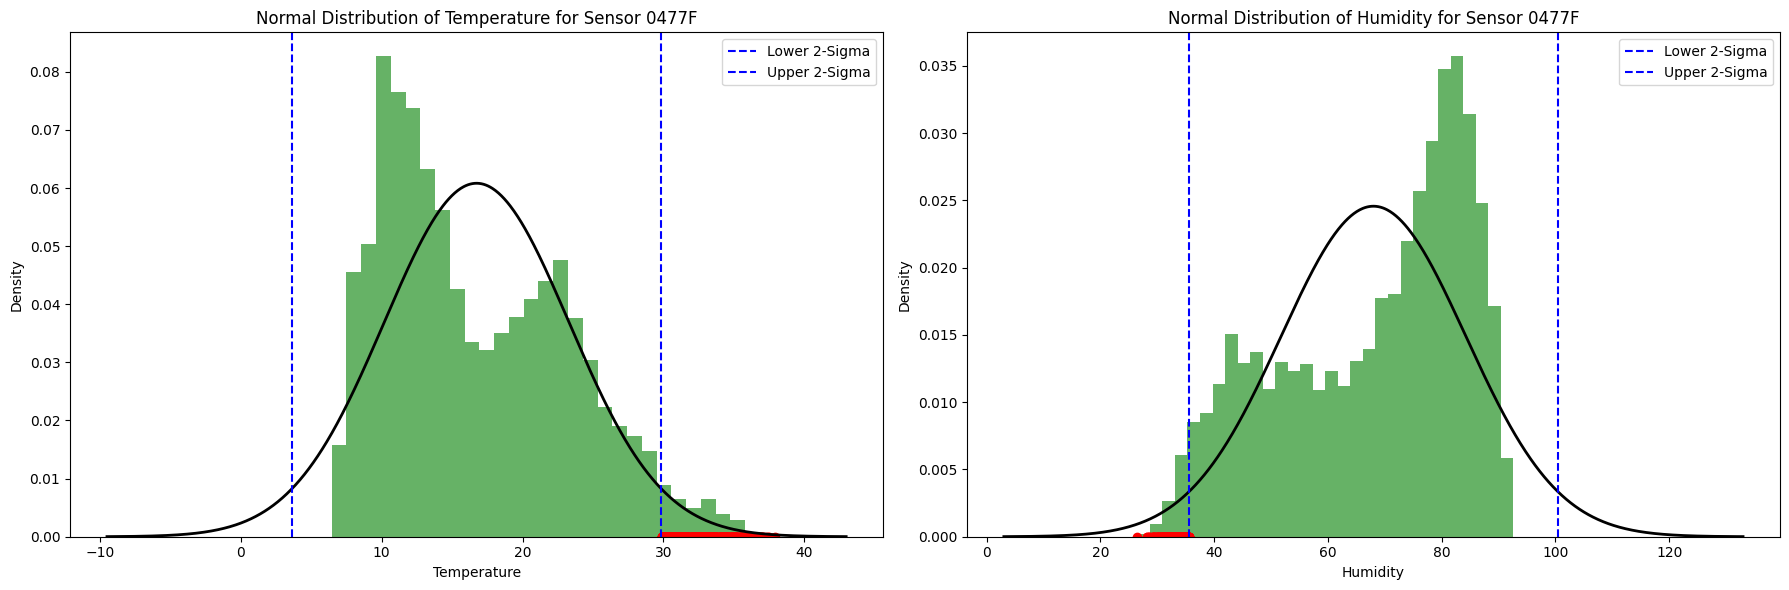

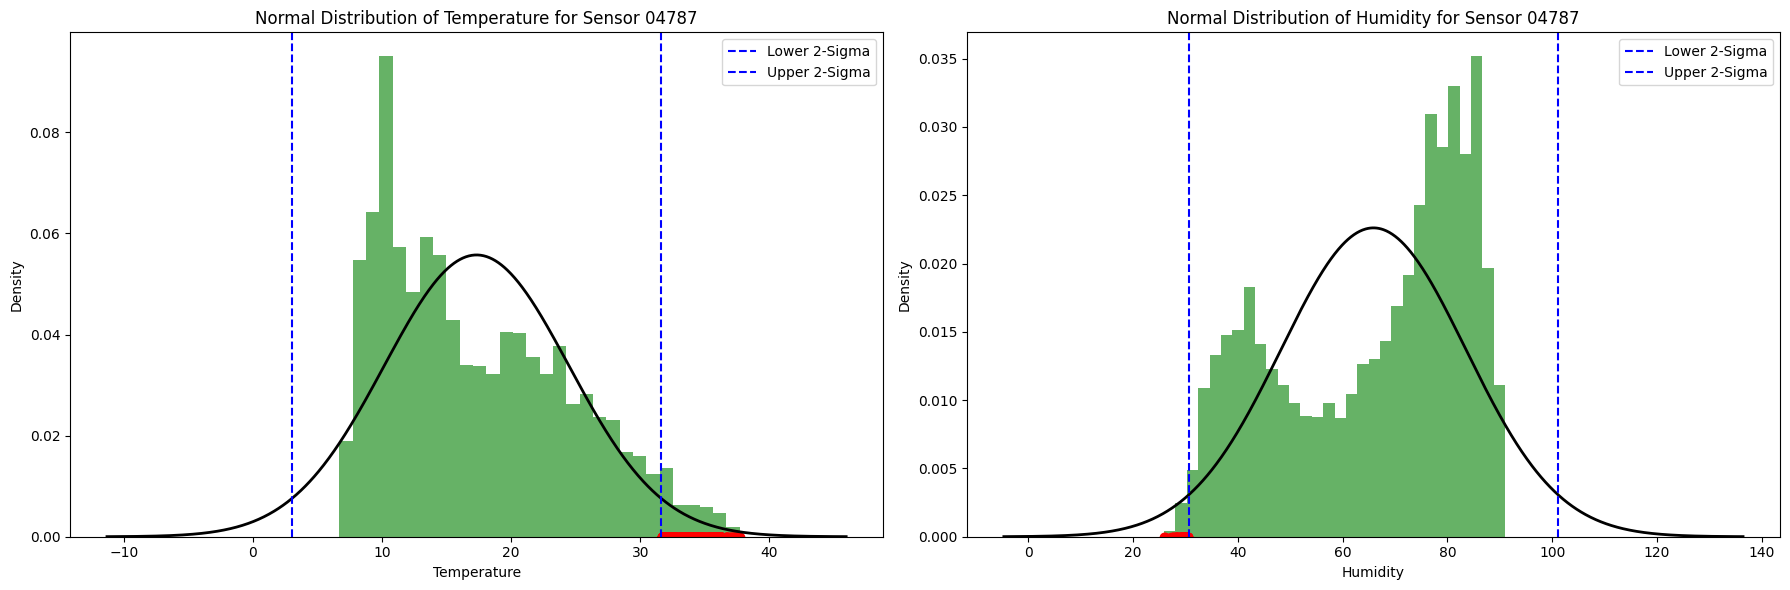

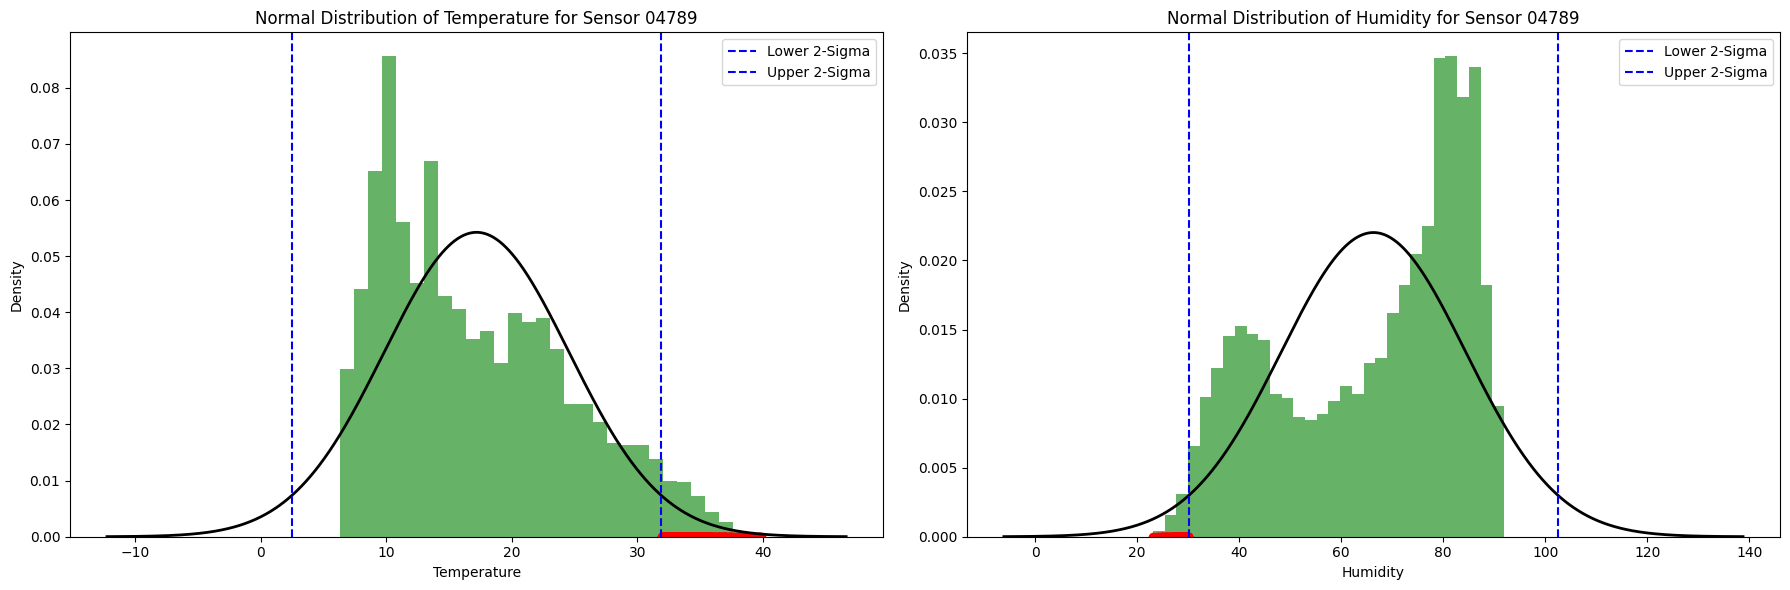

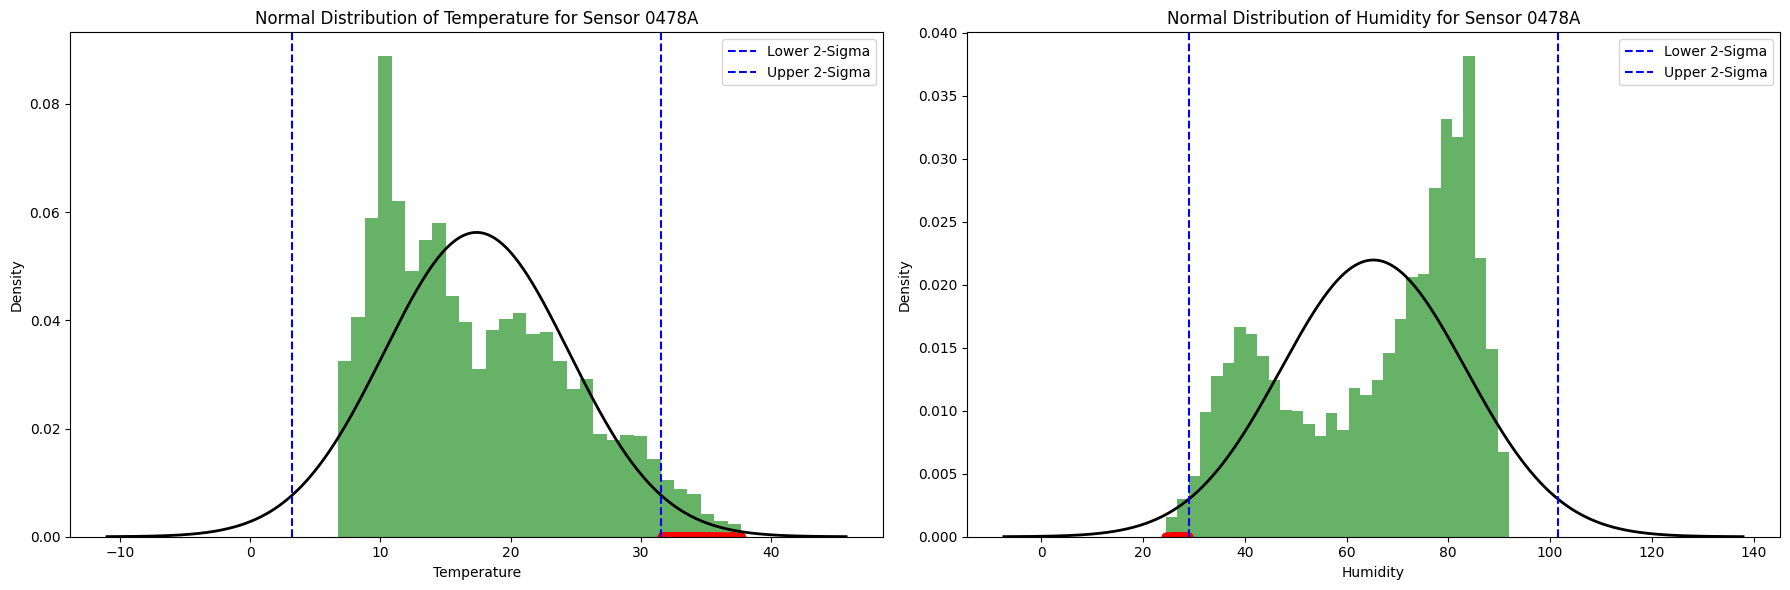

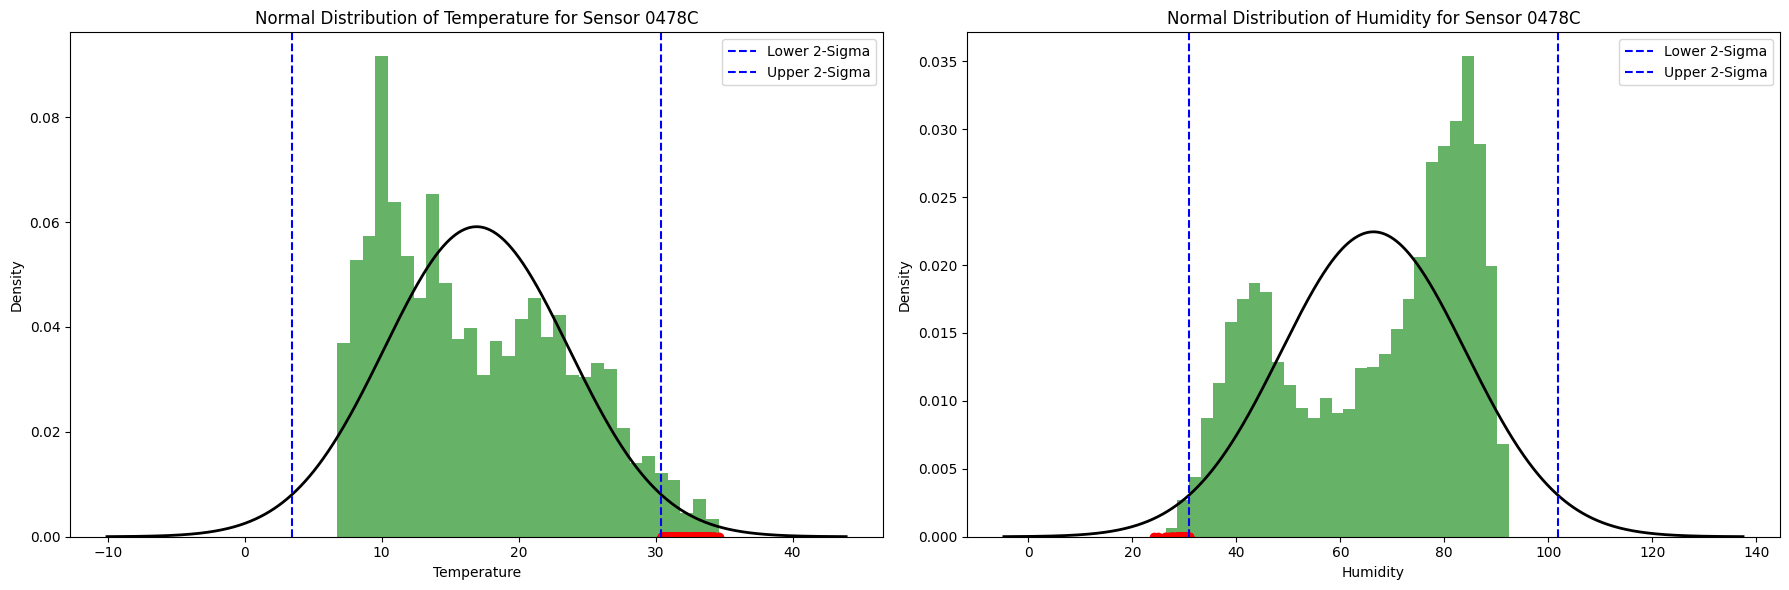

In [26]:
anomalies_list = []

for sensor_id, sensor_data in final_dataset.groupby('Sensor ID'):
    sensor_anomalies = detect_anomalies(sensor_data, sensor_id)
    anomalies_list.append(sensor_anomalies)

In [27]:
all_anomalies = pd.concat(anomalies_list)

In [28]:
non_anomalous_data = all_anomalies[(all_anomalies['Temperature_anomaly'] == 0) & (all_anomalies['Humidity_anomaly'] == 0)]

X_train = non_anomalous_data[['Temperature', 'Humidity']]
y_train_temp = non_anomalous_data['Temperature']
y_train_humidity = non_anomalous_data['Humidity']

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [30]:
def anomalay_model(input_dim):
    model = ker.models.Sequential([
        ker.layers.Dense(64, input_dim=input_dim, activation='relu'),
        ker.layers.Dense(64, activation='relu'),
        ker.layers.Dense(32, activation='relu'),
        ker.layers.Dense(1)
    ])
    model.compile(optimizer=ker.optimizers.Adam(learning_rate=0.01), loss='mse')
    return model

In [31]:
anomaly_model_temp = anomalay_model(input_dim=2)
anomaly_model_temp.fit(X_train_scaled, y_train_temp, epochs=100, batch_size=32, verbose=0)

e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
anomaly_model_humidity = anomalay_model(input_dim=2)
anomaly_model_humidity.fit(X_train_scaled, y_train_humidity, epochs=100, batch_size=32, verbose=0)

e:\Final Desertation\env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [33]:
# mlp_temp = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)
# mlp_humidity = MLPRegressor(hidden_layer_sizes=(20, 20), max_iter=500, random_state=42)

In [34]:
# mlp_temp.fit(X_train_scaled, y_train_temp)

In [35]:
# mlp_humidity.fit(X_train_scaled, y_train_humidity)

In [36]:
anomalies = all_anomalies[(all_anomalies['Temperature_anomaly'] == 1) & (all_anomalies['Humidity_anomaly'] == 1)].copy()

X_anomalies = anomalies[['Temperature', 'Humidity']]
X_anomalies_scaled = scaler.transform(X_anomalies)

In [37]:
anomalies['Temperature'] = np.round(anomaly_model_temp.predict(X_anomalies_scaled), 2)
anomalies['Humidity'] = np.round(anomaly_model_humidity.predict(X_anomalies_scaled), 2)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [38]:
all_anomalies.update(anomalies[['Temperature', 'Humidity']])

In [43]:
anomalies.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
16155,2024-04-30 11:38:03,30.650000,34.900002,04750,04750 T/RH IP67,1,1
16163,2024-04-30 12:18:06,31.549999,34.000000,04750,04750 T/RH IP67,1,1
16165,2024-04-30 12:28:04,31.600000,34.299999,04750,04750 T/RH IP67,1,1
16167,2024-04-30 12:38:06,32.200001,33.799999,04750,04750 T/RH IP67,1,1
16168,2024-04-30 12:43:05,32.049999,34.299999,04750,04750 T/RH IP67,1,1


In [39]:
final_processed_data = all_anomalies.copy()

In [40]:
final_processed_data.head()

,Time,Temperature,Humidity,Sensor ID,Sensor Name,Temperature_anomaly,Humidity_anomaly
0,2024-04-16 13:09:53,21.95,50.3,0474D,0474D T/RH IP67,0,0
1,2024-04-16 13:14:52,22.50,34.7,0474D,0474D T/RH IP67,0,0
2,2024-04-16 13:19:54,24.05,34.7,0474D,0474D T/RH IP67,0,0
3,2024-04-16 13:24:53,24.25,34.7,0474D,0474D T/RH IP67,0,0
4,2024-04-16 13:29:52,24.15,35.2,0474D,0474D T/RH IP67,0,0
